#**Images and Words**
This project pretends to use common Deep Learning techniques more commonly used on the fields of image and/or speech in order to improve current methods of music generation.

<b>Rember to set up Python 3 with GPU!!!!!!</b>

<a href='https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5'>Link</a> to the original article where I found the whole thing. It is interesting specially when it comes to the data pre-traitment. I think it is a little bit amateur... (Base on some of the coding)

Introducing the <a href='https://github.com/bearpelican/music_rnn/blob/master/bachbot/BachBot-StackedLSTMs.ipynb' >bearpelican</a> pytorch implementation:



##*1. Libraries*
They should run correctly in colab and in local as long as you use Python 3.

The key library is music21, central to the whole pre-traitement of the midi dataset. It has been developed by the MIT and you can find here the <a href='http://web.mit.edu/music21/doc/index.html'> documentation</a>.


In [0]:
import glob
import pickle
import numpy as np
from music21 import converter, instrument, note, chord, stream

from os import walk
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


##*1. HyperParameters*

In [0]:
QNSF = 4   #  Quarter Note Sampling frequency for dividing time 

COD_TYPE = 2  #  1 is 88 notes, 2 is 176 where position 0 is starting note, 1 is continuation note 

SEQ_LEN=4*4*QNSF  # secuencia de notas de entrada   (SEQ_LEN / QNSF)  son las notas de entrada

print("Input quarter notes:{} with code_type:{} ".format(SEQ_LEN / QNSF, COD_TYPE))

BATCH_SIZE_TRAIN=50  # batch for the train 
BATCH_SIZE_VAL=15  # batch for the validation
BATCH_SIZE_TEST=50  # batch for the test

EPOCHS=100

DATA_LEN_TRAIN=10  #Number of songs used for Data Generator (-1 for all) for train
DATA_LEN_VAL=3  #Number of songs used for Data Generator (-1 for all) for validation
DATA_LEN_TEST=3   #Number of songs used for Data Generator (-1 for all) test
# time 2:20
#DATA_LEN=34 #Number of songs used for Data Generator (-1 for all)
# time 5:10
#DATA_LEN=67 #Number of songs used for Data Generator (-1 for all)

MIDI_SOURCE = "tempData/midi"    #  directory with *.midi files
#MIDI_SOURCE = "/content/Classical-Piano-Composer/midi_songs"   #  direc
#MIDI_SOURCE = "TPDData/TPD/classical"
#MIDI_SOURCE = "TPDData/TPD/jazz"


SILENCE=1 #Encode Silence as a distinct pitch


Input quarter notes:16.0 with code_type:2 


#Dataset

##*0. Load Dataset*##

###*0.1 Load Dataset JSBChorales.net*###

JSBChorales.net

In [0]:
!curl https://www.dropbox.com/s/1l0m07pwgk0305t/jsb403.zip?dl=0 -L -o jsb403.zip
!mkdir tempData
!unzip jsb403.zip -d tempData
#!ls tempData/midi


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   990    0   990    0     0    826      0 --:--:--  0:00:01 --:--:--  2066
100  659k  100  659k    0     0   412k      0  0:00:01  0:00:01 --:--:--  412k
Archive:  jsb403.zip
   creating: tempData/midi/
  inflating: tempData/midi/.DS_Store  
   creating: tempData/__MACOSX/
   creating: tempData/__MACOSX/midi/
  inflating: tempData/__MACOSX/midi/._.DS_Store  
  inflating: tempData/midi/000101b_.mid  
  inflating: tempData/__MACOSX/midi/._000101b_.mid  
  inflating: tempData/midi/000106b_.mid  
  inflating: tempData/__MACOSX/midi/._000106b_.mid  
  inflating: tempData/midi/000106trio.mid  
  inflating: tempData/__MACOSX/midi/._000106trio.mid  
  inflating: tempData/midi/000

###*0.2. Load Datset 2*###

In [0]:
#Clone the original git, just for the dataset (I think is base on Final Fantasy scores...)
!git clone https://github.com/Skuldur/Classical-Piano-Composer.git

#It also helps with the directories

Cloning into 'Classical-Piano-Composer'...
remote: Enumerating objects: 183, done.
remote: Total 183 (delta 0), reused 0 (delta 0), pack-reused 183
Receiving objects: 100% (183/183), 200.11 MiB | 41.72 MiB/s, done.
Resolving deltas: 100% (29/29), done.


###*0.3. Load Datset 3*###

Dataset Link : [Piano Dataset](http://imanmalik.com/assets/dataset/TPD.zip)

Note: The Piano Dataset is distributed with a [CC-BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). If you use this dataset, please reference this [paper](https://arxiv.org/abs/1708.03535):

Dataset Link(SeqGAN) : [Nottingham Database](http://ifdo.ca/~seymour/nottingham/nottingham.html)

In [0]:
!curl http://imanmalik.com/assets/dataset/TPD.zip -o TPD.zip
!mkdir TPDData
!unzip TPD.zip -d TPDData


##*1. Generator (MIDI to Text)*


In [0]:
class MidiDataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, qnsf, seq_len=25, cod_type=1, midi_files=[]):
        'Initialization'
        if cod_type !=1 and cod_type !=2:  
          raise TypeError("cod_type is not 1 (88 notes) or 2 (176 notes)")
        self.notes = self.get_notes(qnsf=qnsf, cod_type=cod_type, midi_files=midi_files)
        self.qnsf = qnsf
        self.seq_len = seq_len
        self.cod_type = cod_type
        self.midi_source = midi_files
        


  def __len__(self):
        'Denotes the total number of samples'
        return len(self.notes) - self.seq_len*2

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        samples = self.notes[index:(index+self.seq_len*2)]
        x=np.asarray(samples).astype(np.float32)
        
        return (x[0:self.seq_len,:],x[self.seq_len:,:])
        #return  (samples[0:self.seq_len], samples[self.seq_len:])
      
  def get_notes(self, qnsf, cod_type,midi_files):
      """ Get all the notes and chords from the midi files in the ./midi_songs directory """
      notes = []

      for i,file in enumerate(midi_files):

          
          midi = converter.parse(file)

          print("Parsing %s" % file)
          
          
          try: # file has instrument parts
              s2 = instrument.partitionByInstrument(midi)
              notes_to_parse = s2.parts[0].recurse() 
          except: # file has notes in a flat structure
              notes_to_parse = midi.flat.notes

              #initialize piano roll
          length=int(notes_to_parse[-1].offset*qnsf)+1 #count number subdivisions
          notes_song=np.zeros((length,88*cod_type))

          for element in notes_to_parse:
              #print(element.offset, element.duration.quarterLength, element.pitch.midi-21)
              if isinstance(element, note.Note):
                  # cod_type is based on (0,1), (1,0), (0,0)
                  notes_song[int(element.offset*qnsf),cod_type*(element.pitch.midi-21)]=1.0    
                  notes_song[(int(element.offset*qnsf)+1):(int(element.offset*qnsf)+int(element.duration.quarterLength*qnsf)),cod_type*(element.pitch.midi-21)+1]=1.0   

              elif isinstance(element, chord.Chord):
                  for note_in_chord in element.pitches:
                    # cod_type is based on (0,1), (1,0), (0,0)
                    notes_song[int(element.offset*qnsf),cod_type*(note_in_chord.midi-21)]=1.0   
                    notes_song[(int(element.offset*qnsf)+1):(int(element.offset*qnsf)+int(element.duration.quarterLength*qnsf)),cod_type*(note_in_chord.midi-21)+1]=1.0   
              #print(notes_song.shape)
                   
          notes+=[list(i) for i in list(notes_song)]
      return notes


def list_midi_files(midi_source, data_len_train, data_len_val , data_len_test, randomSeq=True, seed = 666):
  midi_files_all = []
  for (dirpath, dirnames, filenames) in walk(midi_source):
    midi_files_all.extend(filenames)
  midi_files_all = [ glob.glob(midi_source+"/"+fi)[0] for fi in midi_files_all if fi.endswith(".mid") ]
  
  if randomSeq:
    random.seed( seed )
    midi_files_sel = random.sample(midi_files_all, (data_len_train + data_len_val + data_len_test))
  else:
    midi_files_sel = midi_files_all
    
  
  return midi_files_sel[:data_len_train], midi_files_sel[data_len_train:(data_len_train + data_len_val)], midi_files_sel[(data_len_train + data_len_val):]



In [0]:
#!cp variacio.mid tempData/midi
#revisa= MidiDataset(qnsf=1, seq_len=20, cod_type=2,midi_files=["tempData/midi/032100b_.mid"]).__getitem__(0)[0]
#revisa= MidiDataset(qnsf=1, seq_len=20,midi_files=["tempData/midi/variacio.mid"]).__getitem__(0)[0]
#revisa.sum(1)
#revisa.argmax(1)
#s = converter.parse("tempData/midi/032100b_.mid")
#s._elements[2].__dict__


##*2. Load Training Generator*

Separate the whole dataset into consecutive sequeces

In [0]:
midi_files_train, midi_files_val, midi_files_test  = list_midi_files(MIDI_SOURCE, DATA_LEN_TRAIN, DATA_LEN_VAL, DATA_LEN_TEST, randomSeq=True)

print(midi_files_train)
dataset_train=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_train)
print(len(dataset_train))
print(midi_files_val)
dataset_val=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_val)
print(len(dataset_val))
print(midi_files_test)
dataset_test=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=midi_files_test)
print(len(dataset_test))

training_generator = data.DataLoader(dataset_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
validating_generator = data.DataLoader(dataset_val, batch_size=BATCH_SIZE_VAL, shuffle=True)
testing_generator = data.DataLoader(dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=True)

for batch in training_generator:
    break
print(batch[0].shape)
for batch in validating_generator:
    break
print(batch[0].shape)
for batch in testing_generator:
    break
print(batch[0].shape)



['tempData/midi/042700b_.mid', 'tempData/midi/003608b2.mid', 'tempData/midi/003907b_.mid', 'tempData/midi/035200b_.mid', 'tempData/midi/029300b_.mid', 'tempData/midi/019007b_.mid', 'tempData/midi/028500b_.mid', 'tempData/midi/001306b_.mid', 'tempData/midi/024846b5.mid', 'tempData/midi/028800b_.mid']
Parsing tempData/midi/042700b_.mid
Parsing tempData/midi/003608b2.mid
Parsing tempData/midi/003907b_.mid
Parsing tempData/midi/035200b_.mid
Parsing tempData/midi/029300b_.mid
Parsing tempData/midi/019007b_.mid
Parsing tempData/midi/028500b_.mid
Parsing tempData/midi/001306b_.mid
Parsing tempData/midi/024846b5.mid
Parsing tempData/midi/028800b_.mid
2180
['tempData/midi/065000b_.mid', 'tempData/midi/028400b_.mid', 'tempData/midi/034300b_.mid']
Parsing tempData/midi/065000b_.mid
Parsing tempData/midi/028400b_.mid
Parsing tempData/midi/034300b_.mid
1625
['tempData/midi/018506b_.mid', 'tempData/midi/022707b_.mid', 'tempData/midi/032500b_.mid']
Parsing tempData/midi/018506b_.mid
Parsing tempData/

#Models

##*1. Simple Dropout LSTM*

In [0]:
class NextNoteModel(nn.Module):
  def __init__(self, input_dim, rnn_dim=512, rnn_layers=2):
      super(NextNoteModel, self).__init__()
      self.rnn = nn.LSTM( input_size=input_dim, hidden_size=rnn_dim, num_layers=rnn_layers, batch_first=True, dropout=0.2)
      self.classifier = nn.Sequential(
          nn.Linear(rnn_dim, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, input_dim)
      )
      self.loss_function = nn.CrossEntropyLoss() #combina logsoftmax y NLLLoss
      
  def forward(self, x):          
#           output, (hn, cn) = rnn(input, (h0, c0))
      output, (hn, cn) = self.rnn(x)
      return self.classifier(output[:,-1,:]) #no hace falta la softmax
    
  def loss(self, x,y):
      y_pred = y.argmax(dim=1)
      return self.loss_function(x,y_pred)
    
  
  def accuracy(self, x, y):
      x_pred = x.argmax(dim=1)
      y_pred = y.argmax(dim=1)
      return (x_pred == y_pred).float().mean()

##*2. Seq2Seq*

https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

In [0]:
class Seq2Seq(nn.Module):
  def __init__(self, input_dim, rnn_dim=512, rnn_layers=2, thr=0):
      super(Seq2Seq, self).__init__()
      
      self.thr=thr
      self.input_dim=input_dim
      self.rnn_dim=rnn_dim
      
      self.encoder = nn.LSTM( input_size=input_dim, hidden_size=rnn_dim, num_layers=rnn_layers, batch_first=True, dropout=0.2)
      self.decoder = nn.LSTM( input_size=input_dim, hidden_size=rnn_dim, num_layers=rnn_layers, batch_first=True, dropout=0.2)
      self.classifier = nn.Sequential(
          nn.Linear(rnn_dim, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, input_dim)
      )

      self.loss_function = nn.BCEWithLogitsLoss() #combina logsoftmax y NLLLoss
      
      self.soft = nn.Softmax()
      
  def forward(self, x,y):          

      output, (hn, cn) = self.encoder(x)

      output, (hn, cn) = self.decoder(y, (hn,cn))
      
      shape = output.shape
      
      x=output.unsqueeze(2)
      
      x = self.classifier(x)
      
      x = x.view(shape[0],shape[1],-1)
      
      return x
    
    
  def loss(self, x,y):
      x = x.view(-1,x.shape[2])
      y_pred = y.view(-1,y.shape[2])

      return self.loss_function(x,y_pred)

  def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [batch_size, n_forecast, n_classes(or n_levels)].
          y: (tensor) sized like x.
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.5
        gamma = 2.0
        
        x = x.view(-1,x.shape[2])
        y = y.view(-1,y.shape[2])

        t = y.float()

        p = x.sigmoid().detach()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')
  
  def accuracy(self,x,y):
      x_pred = (x > self.thr).long() #if BCELoss expects sigmoid -> th 0.5, BCELossWithLogits expect real values -> th 0.0
      return (x_pred.float() == y).float().mean()
  
  def accuracy_old(self, x, y):
      #flatten
      x_pred = x.argmax(dim=1)
      y_pred = y.argmax(dim=1)
      return (x_pred == y_pred).float().mean()
  
  def init_hidden_predict(self):
        
      # initialize the hidden state and the cell state to zeros
      # batch size is 1
      return (torch.zeros(2,1, self.rnn_dim),torch.zeros(2,1, self.rnn_dim))
  
  
  def predict(self,seq_len=500):

        self.eval()
        
        seq = torch.zeros(1,seq_len+1,self.input_dim).to(device)
        
        hn,cn=self.init_hidden_predict()
        hn=hn.to(device)
        cn=cn.to(device)
        
        
        # for the sequence length
        for t in range(seq_len):

            output, (hn, cn) = self.decoder(seq[0,t].view(1,1,-1),(hn,cn))
            
            output = self.classifier(output)
            
            seq[0,t+1]=output>self.thr
            '''
            output = F.softmax(output, dim=2)
            
            p, top_notes = output.topk(top)
            
            
            if 0 in top_notes:
                seq[0,t+1,0]=1.0
            else:
                top_notes = top_notes.squeeze().cpu().numpy()
                p = p.detach().squeeze().cpu().numpy()
                seq[0,t+1,np.random.choice(top_notes, p = p/p.sum())]=1.0
                print(seq[0,t+1,np.random.choice(top_notes, p = p/p.sum())])
            '''
        return seq[0,1:,:]

#Training

#*1. Train Seq2One*

In [0]:
%%time
# init model
model = NextNoteModel(88*COD_TYPE)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# trainin validation

# EPOCHS = 100

loss_train=[]
acc_train=[]
loss_val=[]
acc_val=[]

for epoch in range(EPOCHS):
  for i,batch in enumerate(training_generator):
        # Forward pass: Compute predicted y by passing x to the model
        x = batch[0]
        y = batch[1][:,0,:]
        x= x.to(device)
        y= y.to(device)
        y_pred = model.train()(x)
       

        # Compute and print loss
        loss = model.loss(y_pred, y)
        acc  = model.accuracy(y_pred, y)


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
  loss_train.append(loss.item())
  acc_train.append(acc.item())
  
  if epoch%10==0:
    for i, batch in enumerate(validating_generator):
          loss_list = []
          acc_list = []
          x = batch[0]
          y = batch[1][:,0,:]
          x= x.to(device)
          y= y.to(device)
          y_pred = model.eval()(x)

          # Compute and print loss
          loss = model.loss(y_pred, y)
          acc  = model.accuracy(y_pred, y)
          loss_list.append(loss.item())
          acc_list.append(acc.item())
  else:
          loss_list.append(loss_list[-1])
          acc_list.append(acc_list[-1])
    
  loss_val.append(np.asarray(loss_list).mean())
  acc_val.append(np.asarray(acc_list).mean())


  print(epoch, loss_train[epoch], loss_val[epoch], acc_train[epoch], acc_val[epoch])

seq2oneMod = model


0 3.900423049926758 4.751437187194824 0.1875 0.0
1 3.7298624515533447 4.751437187194824 0.125 0.0
2 3.70011830329895 4.751437187194824 0.125 0.0
3 3.7687315940856934 4.751437187194824 0.0625 0.0
4 3.727893590927124 4.751437187194824 0.0 0.0
5 3.28770112991333 4.751437187194824 0.0625 0.0
6 4.151397705078125 4.751437187194824 0.0 0.0
7 3.8478293418884277 4.751437187194824 0.125 0.0
8 3.9602339267730713 4.751437187194824 0.0 0.0
9 3.724440097808838 4.751437187194824 0.0625 0.0
10 4.045206546783447 5.445213794708252 0.0625 0.0
11 3.824687957763672 5.445213794708252 0.1875 0.0
12 3.6579740047454834 5.445213794708252 0.125 0.0
13 3.1985979080200195 5.445213794708252 0.125 0.0
14 3.969972610473633 5.445213794708252 0.0 0.0
15 3.629863739013672 5.445213794708252 0.0 0.0
16 3.420071601867676 5.445213794708252 0.1875 0.0
17 3.3325002193450928 5.445213794708252 0.0625 0.0
18 3.3196568489074707 5.445213794708252 0.0625 0.0
19 3.7079226970672607 5.445213794708252 0.0625 0.0
20 3.183175563812256 4.

##*Plot Results*

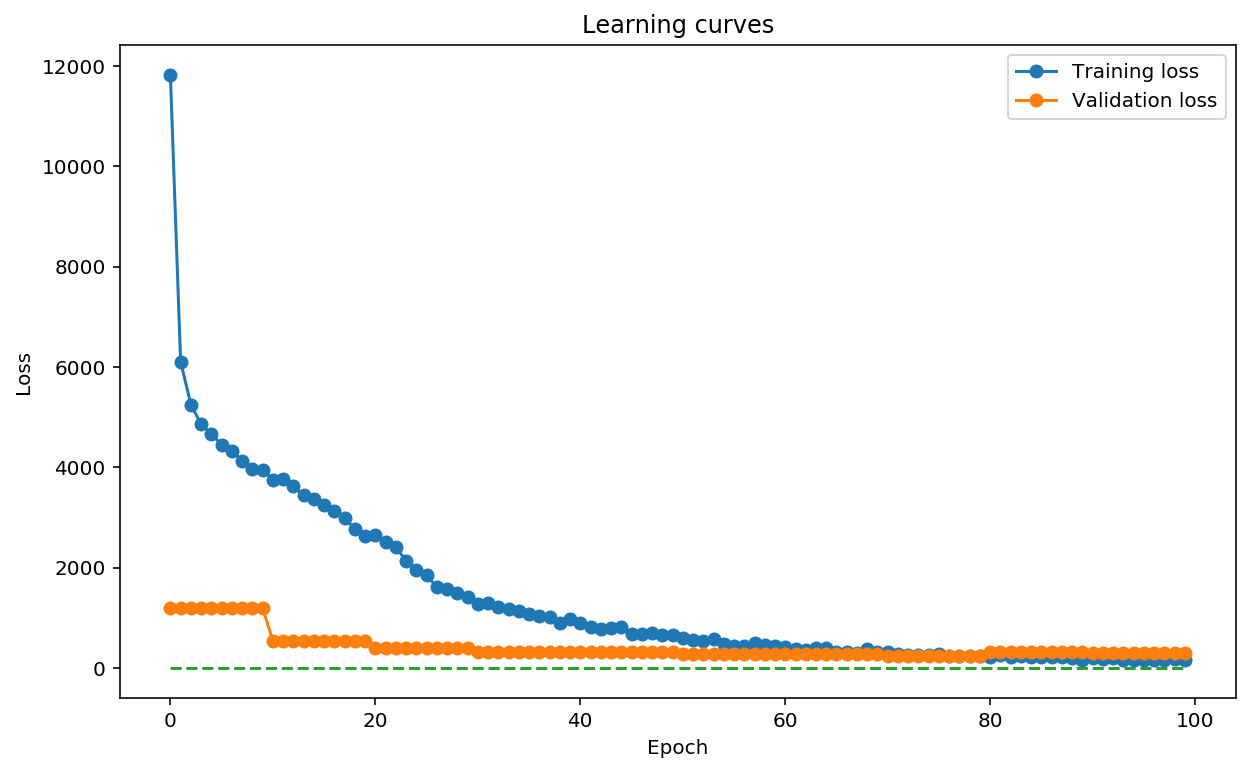

In [0]:
epochs = range(EPOCHS)

loss_obj=[0]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_train, '-o', label='Training loss')
plt.plot(epochs, loss_val, '-o', label='Validation loss')
plt.plot(epochs, loss_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

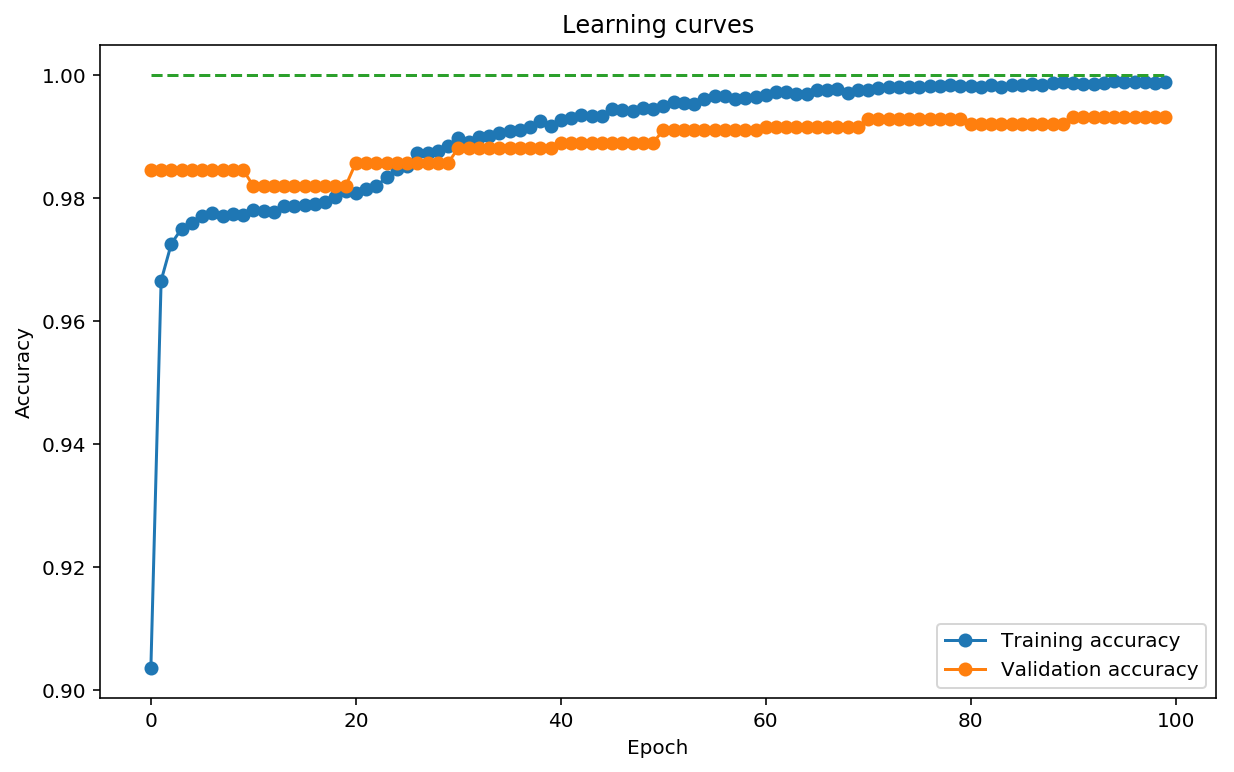

In [0]:
epochs = range(EPOCHS)

acc_obj=[1]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, acc_train, '-o', label='Training accuracy')
plt.plot(epochs, acc_val, '-o', label='Validation accuracy')
plt.plot(epochs, acc_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##Test#

In [0]:
# test

loss_test=[]
acc_test=[]

for i,batch in enumerate(testing_generator):
  x = batch[0]
  y = batch[1][:,0,:]
  x= x.to(device)
  y= y.to(device)
  y_pred = seq2oneMod.eval()(x)
  
  # Compute and print loss
  loss = seq2oneMod.loss(y_pred, y)
  acc  = seq2oneMod.accuracy(y_pred, y)
  
  loss_test.append(loss.item())
  acc_test.append(acc.item())

print(np.asarray(loss_test).mean(), np.asarray(acc_test).mean())
print(np.asarray(loss_test).std(), np.asarray(acc_test).std())


NameError: ignored

##Generating/predicting#

In [0]:
def generateSeq2one(x, model ,pred_len=120):
  z= x.to(device)
  x1shape = x.shape[1]
  pred_shape=list(x.shape[1:])
  pred_shape[0] += pred_len
  pred_test=np.zeros(pred_shape)
  pred_test[0:x1shape,:] = x[0,:,:].numpy()                # we take the firdt samples from x 
  for i in range(pred_len):                                # predicting 
    y_pred = model.eval()(z)
    z[:,:-1,:] = z[:,1:,:]                # removing firt note
    z[0,-1,:]=0.0                         # add predicted note at the end
    z[0,-1,:][y_pred.argmax(dim=1)]=1.0   # add predicted note at the end  WARNING it be caodief here the 0.5 note
    pred_test[x1shape + i,:] = z[0,-1,:].cpu().numpy()  # add the new predicted to the pred_test
  return pred_test

def cleanSeq(x, cod_type):
  if cod_type==2:
    # first row correction
    notePos = np.where(x[0,:]==1)[0]        # where are the ones
    notePosWrong = np.array([aa%2 for aa in notePos])  
    notePosWrongPos = np.where(notePosWrong==1)[0]     # we look if corespond to odd positions
    x[0,notePos[notePosWrongPos]]=0                    # if present, we correct to 0 the odd
    x[0,notePos[notePosWrongPos]-1]=1                  # if present, we correct to 0 the correspondent even position
    
    # other rows correction
    # when we have 1 in even and odd position, then remove the second one 
    x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] = x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] * (1-x)[:,[ii for ii in range(x.shape[1]) if ii%2==0 ] ]

    # now we want to compare with previous row
    x_0 = x[1:,1:]     #   base values to correct
    x_1 = x[0:-1,1:]   #   previous same column
    x_11 = x[0:-1,0:-1]#   previous even column
    x_sel = np.zeros(x_0.shape)  # odd columns f x
    x_sel[:, [ii for ii in range(x_sel.shape[1]) if ii%2==0 ] ] =1   # corespond to even columns of x_sel
    x_2 = ((x_1==0) & (x_11==0) & (x_0==1) & (x_sel==1))   # columns with one in odd that not have any in even or odd correspondece in previous row
    x[1:,1:][x_2] = 0    # correction in unpair row
    x[1:,:-1][x_2] = 1
    
  return(x)


def create_midi(prediction_output, qnsf = 4, cod_type=2, midiOutputFile='test_output.mid'):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i,pattern in enumerate(prediction_output):
      # pattern is a note
      notes = []
      noteIndex = np.where(pattern==1)[0]
      noteIndex = noteIndex[[ii % cod_type ==0 for ii in noteIndex]]
      if len(noteIndex)>0:  
        for current_note in noteIndex:
          new_note = note.Note(int(current_note/cod_type + 21))
          new_note.storedInstrument = instrument.Piano()
          new_note.offset = offset
          # duration.quarterLength in case cod_type==2
          if cod_type==2 :
            # sequence of duration equal to one in the odd position
            auxDuration = np.where(prediction_output[(i+1):,current_note + 1]==1)[0]
            # initialize duration
            minimum_value = 0
            if len(auxDuration)>0:
              # minimum position where we have a consecuive sequence at 0
              # we add one to include complete sequences
              minimum_value = np.array(range(len(auxDuration)+1))[~np.isin(range(len(auxDuration)+1),auxDuration)].min()

            # we calcuate the minimum number in the sequance :len(auxDuration) that is not 
            # in the sequence, add one and divide by QNSF
            new_note.duration.quarterLength = ( minimum_value + 1.0)/qnsf
            
          output_notes.append(new_note)

      offset += 1.0/qnsf
    
    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=midiOutputFile)
    print("created midi file: ",midiOutputFile )


In [0]:
# generated length
PRED_LEN = 60

# we recover one song for the first sequence
pred_generator = data.DataLoader(dataset_test, batch_size=15, shuffle=False)
# pred

# transform to input tensor last batch
for i,batch in enumerate(pred_generator):
  xinit = batch[0]
#  break

pred_test = generateSeq2one(xinit,seq2oneMod,PRED_LEN)
pred_test_clean = cleanSeq(pred_test, cod_type=COD_TYPE)
create_midi(pred_test_clean, qnsf = QNSF, cod_type=COD_TYPE, midiOutputFile='test_output.mid')


NameError: ignored

#*2. Train Seq2Seq*

In [0]:
%%time
# init model
model = Seq2Seq(88*COD_TYPE)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

CPU times: user 93 ms, sys: 13 ms, total: 106 ms
Wall time: 118 ms


In [0]:


# trainin validation

# EPOCHS = 3

loss_train=[]
acc_train=[]
loss_val=[]
acc_val=[]

for epoch in range(EPOCHS):
  for i,batch in enumerate(training_generator):
        # Forward pass: Compute predicted y by passing x to the model
        x = batch[0]
        y = batch[1]
        x= x.to(device)
        y= y.to(device)
        y_pred = model.train()(x,y)
       

        # Compute and print loss
        loss = model.focal_loss(y_pred, y)
        acc  = model.accuracy(y_pred, y)


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
  loss_train.append(loss.item())
  acc_train.append(acc.item())
  
  # break
  
  if epoch%10==0:
    for i, batch in enumerate(validating_generator):
          loss_list = []
          acc_list = []
          x = batch[0]
          y = batch[1]
          x= x.to(device)
          y= y.to(device)
          y_pred = model.eval()(x,y)

          # Compute and print loss
          loss = model.focal_loss(y_pred, y)
          acc  = model.accuracy(y_pred, y)
          loss_list.append(loss.item())
          acc_list.append(acc.item())
  else:
    loss_list.append(loss_list[-1])
    acc_list.append(acc_list[-1])
    
  loss_val.append(np.asarray(loss_list).mean())
  acc_val.append(np.asarray(acc_list).mean())

  print(epoch, loss_train[epoch], loss_val[epoch], acc_train[epoch], acc_val[epoch])

seq2seqMod = model 

0 11824.806640625 1195.41357421875 0.9036280512809753 0.9845880270004272
1 6106.310546875 1195.41357421875 0.9665749073028564 0.9845880270004272
2 5252.15234375 1195.41357421875 0.9725852012634277 0.9845880270004272
3 4859.3310546875 1195.41357421875 0.9750177264213562 0.9845880270004272
4 4665.3447265625 1195.41357421875 0.9758759140968323 0.9845880270004272
5 4453.4365234375 1195.41357421875 0.9771395325660706 0.9845880270004272
6 4329.49365234375 1195.41357421875 0.9776425957679749 0.9845880270004272
7 4134.57958984375 1195.41357421875 0.9770092964172363 0.9845880270004272
8 3958.72998046875 1195.41357421875 0.9773969650268555 0.9845880270004272
9 3954.177734375 1195.41357421875 0.9772874712944031 0.9845880270004272
10 3754.369140625 541.0243530273438 0.9780243635177612 0.9819424152374268
11 3758.81640625 541.0243530273438 0.9779296517372131 0.9819424152374268
12 3619.96484375 541.0243530273438 0.9777432084083557 0.9819424152374268
13 3441.728759765625 541.0243530273438 0.9786546826

In [0]:
seq2seqMod = model

In [0]:
seq_pred=seq2seqMod.predict()

##*Plot Results*

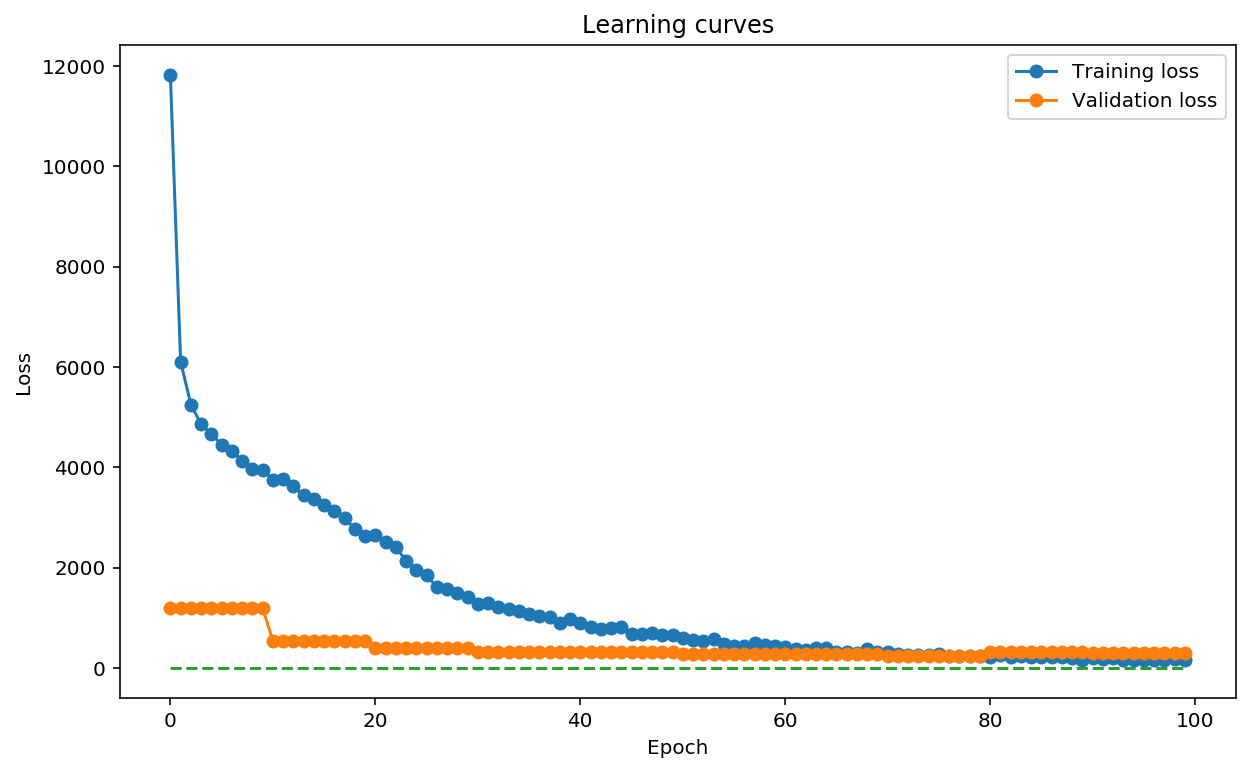

In [0]:
epochs = range(EPOCHS)

loss_obj=[0]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_train, '-o', label='Training loss')
plt.plot(epochs, loss_val, '-o', label='Validation loss')
plt.plot(epochs, loss_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

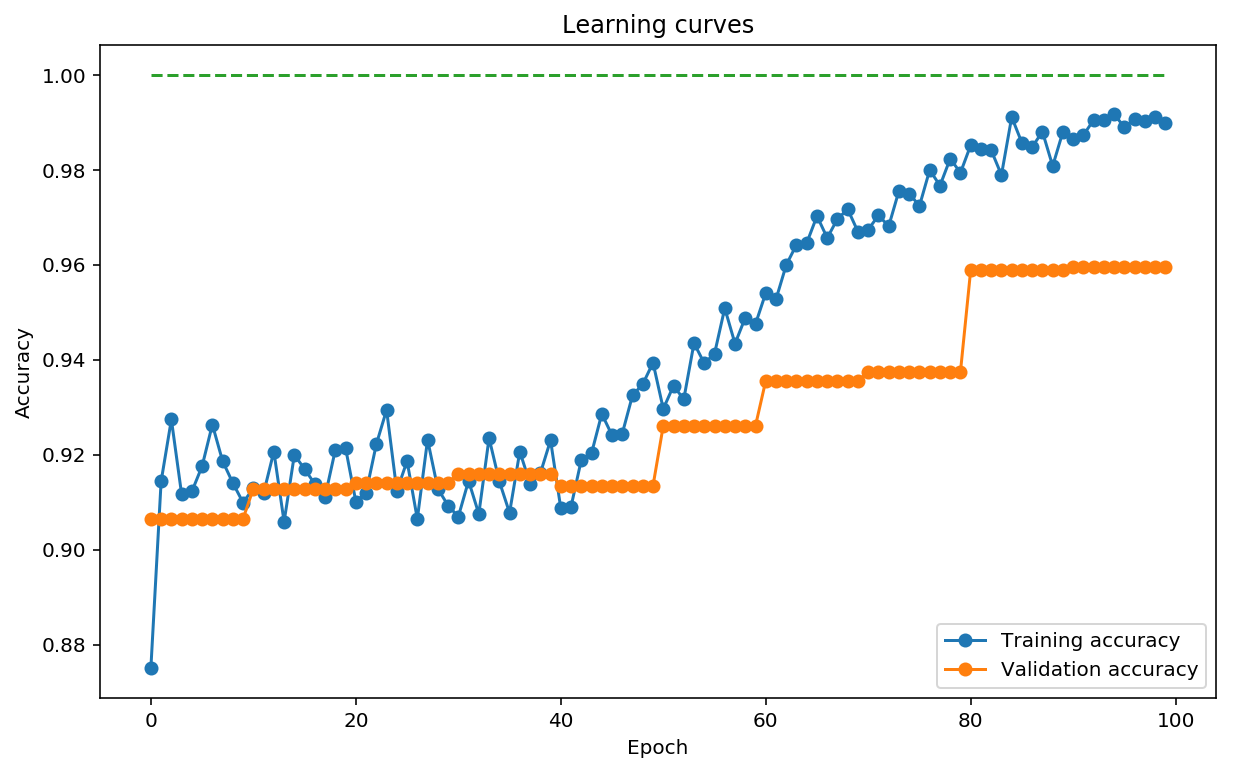

In [0]:
epochs = range(EPOCHS)

acc_obj=[1]*EPOCHS

plt.figure(figsize=(10,6))
plt.plot(epochs, acc_train, '-o', label='Training accuracy')
plt.plot(epochs, acc_val, '-o', label='Validation accuracy')
plt.plot(epochs, acc_obj, '--')

plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

##Test#

In [0]:
# test

loss_test=[]
acc_test=[]

for i,batch in enumerate(testing_generator):
  x = batch[0]
  y = batch[1]
  x= x.to(device)
  y= y.to(device)
  y_pred = seq2seqMod.eval()(x,y)
  
  # Compute and print loss
  loss = seq2seqMod.loss(y_pred, y)
  acc  = seq2seqMod.accuracy(y_pred, y)
  
  loss_test.append(loss.item())
  acc_test.append(acc.item())

print(np.asarray(loss_test).mean(), np.asarray(acc_test).mean())
print(np.asarray(loss_test).std(), np.asarray(acc_test).std())


0.031908561413486795 0.9914840896924336
0.0018519002557062327 0.0004424813494137201


#Generating / Predicting

In [0]:
seq_pred_clean=cleanSeq(seq_pred.cpu().numpy(),2)

print(seq_pred_clean.shape)

print(seq_pred.cpu().numpy().shape)

#create_midi(seq_pred.cpu().numpy())

(500, 176)
(500, 176)


In [0]:
def cleanSeq(x, cod_type):
  if cod_type==2:
    # first row correction
    notePos = np.where(x[0,:]==1)[0]        # where are the ones
    notePosWrong = np.array([aa%2 for aa in notePos])  
    notePosWrongPos = np.where(notePosWrong==1)[0]     # we look if corespond to odd positions
    x[0,notePos[notePosWrongPos]]=0                    # if present, we correct to 0 the odd
    x[0,notePos[notePosWrongPos]-1]=1                  # if present, we correct to 0 the correspondent even position
    
    # other rows correction
    # when we have 1 in even and odd position, then remove the second one 
    x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] = x[:,[ii for ii in range(x.shape[1]) if ii%2==1 ] ] * (1-x)[:,[ii for ii in range(x.shape[1]) if ii%2==0 ] ]

    # now we want to compare with previous row
    x_0 = x[1:,1:]     #   base values to correct
    x_1 = x[0:-1,1:]   #   previous same column
    x_11 = x[0:-1,0:-1]#   previous even column
    x_sel = np.zeros(x_0.shape)  # odd columns f x
    x_sel[:, [ii for ii in range(x_sel.shape[1]) if ii%2==0 ] ] =1   # corespond to even columns of x_sel
    x_2 = ((x_1==0) & (x_11==0) & (x_0==1) & (x_sel==1))   # columns with one in odd that not have any in even or odd correspondece in previous row
    x[1:,1:][x_2] = 0    # correction in unpair row
    x[1:,:-1][x_2] = 1
    
  return(x)


def create_midi(prediction_output, qnsf = 4, cod_type=2, midiOutputFile='test_output.mid'):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i,pattern in enumerate(prediction_output):
      # pattern is a note
      notes = []
      noteIndex = np.where(pattern==1)[0]
      noteIndex = noteIndex[[ii % cod_type ==0 for ii in noteIndex]]
      if len(noteIndex)>0:  
        for current_note in noteIndex:
          new_note = note.Note(int(current_note/cod_type + 21))
          new_note.storedInstrument = instrument.Piano()
          new_note.offset = offset
          # duration.quarterLength in case cod_type==2
          if cod_type==2 :
            # sequence of duration equal to one in the odd position
            auxDuration = np.where(prediction_output[(i+1):,current_note + 1]==1)[0]
            # initialize duration
            minimum_value = 0
            if len(auxDuration)>0:
              # minimum position where we have a consecuive sequence at 0
              # we add one to include complete sequences
              minimum_value = np.array(range(len(auxDuration)+1))[~np.isin(range(len(auxDuration)+1),auxDuration)].min()

            # we calcuate the minimum number in the sequance :len(auxDuration) that is not 
            # in the sequence, add one and divide by QNSF
            new_note.duration.quarterLength = ( minimum_value + 1.0)/qnsf
            
          output_notes.append(new_note)

      offset += 1.0/qnsf
    
    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=midiOutputFile)
    print("created midi file: ",midiOutputFile )

In [0]:

##############    TODO #################

def generateSeq2seq(x, y, model ,pred_seq=1):
  z= x.to(device)
  w= y.to(device)
  x1shape = x.shape[1]
  pred_shape=list(x.shape[1:])
  pred_shape[0] += pred_seq*pred_shape[0]
  pred_test=np.zeros(pred_shape)
  pred_test[0:x1shape,:] = x[0,:,:].numpy()                # we take the firdt samples from x 
  for i in range(pred_seq):                                # predicting 
    y_pred = model.eval()(z,w)
    #pred_test_clean = cleanSeq(pred_test, cod_type=COD_TYPE)

    #z[:,:-1,:] = z[:,1:,:]                # removing firt note
    #z[0,-1,:]=0.0                         # add predicted note at the end
    #z[0,-1,:][y_pred.argmax(dim=1)]=1.0   # add predicted note at the end  WARNING it be caodief here the 0.5 note
    #pred_test[x1shape + i,:] = z[0,-1,:].cpu().numpy()  # add the new predicted to the pred_test
    #print(y_pred.shape)
    y_pred_pos=(y_pred[0,:,:].cpu().detach().numpy()>0)
    for ii in range(len(y_pred_pos)):
      pred_test[x1shape + ii,y_pred_pos[ii]] = 1.0
  return pred_test
  #return pred_test
  


In [0]:
# generated length
PRED_SEQ = 1    #   !!!!  do not change it

#dataset_test2=MidiDataset(qnsf=QNSF, seq_len=SEQ_LEN, cod_type=COD_TYPE, midi_files=['Classical-Piano-Composer/midi_songs/Gold_Silver_Rival_Battle.mid'])


# we recover one song for the first sequence
pred_generator = data.DataLoader(dataset_test, batch_size=1, shuffle=False)
# pred

# transform to input tensor last batch
for i,batch in enumerate(pred_generator):
  xinit = batch[0][0:1,:,:]
  yinit = batch[1][0:1,:,:]
  break

print(xinit.shape)
print(yinit.shape)

pred_test = generateSeq2seq(xinit,yinit,seq2seqMod,pred_seq=PRED_SEQ)
if COD_TYPE==2:
  pred_test_clean = cleanSeq(pred_test, cod_type=COD_TYPE)
else:
  pred_test_clean = pred_test
create_midi(pred_test, qnsf = QNSF, cod_type=COD_TYPE, midiOutputFile='test_seq2seqv2_006.mid')



torch.Size([1, 64, 176])
torch.Size([1, 64, 176])
created midi file:  test_seq2seqv2_006.mid


In [0]:
pred_test = generateSeq2seq(xinit,yinit,seq2seqMod,pred_seq=PRED_SEQ)

create_midi(pred_test, qnsf = QNSF, cod_type=COD_TYPE, midiOutputFile='test_seq2seqv2_004.mid')

In [0]:
.cpu().numpy()

AttributeError: ignored

In [0]:
'Classical-Piano-Composer/midi_songs/Gold_Silver_Rival_Battle.mid'

#*Convert Data Back to Midi*#

#Testeo!!!

Provad aquí abajo

In [0]:
midi_files_test

['tempData/midi/035700b_.mid']